In [2]:
%cd ..

/work/yuxiang1234/sandbox-AND


## Import Package 

In [12]:
import os
import sys

import json
import random
from collections import defaultdict

import matplotlib.pyplot as plt
from nltk import sent_tokenize
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

from args import parser
from data_utils import get_audio_description
from sentence_utils import is_junk_sentence, get_basename

## Arguments

In [4]:
class Arguments:
    def __init__(self):

        self.target_name = "ast-esc50" # Model to dissect (target model)
        
        self.target_layers = "layer0_output,layer0_intermediate,layer0_attention_output, \
                        	  layer1_output,layer1_intermediate,layer1_attention_output, \
                              layer2_output,layer2_intermediate,layer2_attention_output, \
                              layer3_output,layer3_intermediate,layer3_attention_output, \
                              layer4_output,layer4_intermediate,layer4_attention_output, \
                              layer5_output,layer5_intermediate,layer5_attention_output, \
                              layer6_output,layer6_intermediate,layer6_attention_output, \
                              layer7_output,layer7_intermediate,layer7_attention_output, \
                              layer8_output,layer8_intermediate,layer8_attention_output, \
                              layer9_output,layer9_intermediate,layer9_attention_output, \
                              layer10_output,layer10_intermediate,layer10_attention_output, \
                              layer11_output,layer11_intermediate,layer11_attention_output"
        # Which layer neurons to describe. String list of layer names to describe, separated by comma (no spaces). 
        # Follows the naming format of the Pytorch module used.

        # For beats
        # self.target_layers = "layer0_1,layer0_2,layer1_1,layer1_2,layer2_1,layer2_2,layer3_1,layer3_2,layer4_1,layer4_2,layer5_1,layer5_2,layer6_1,layer6_2,layer7_1,layer7_2,layer8_1,layer8_2,layer9_1,layer9_2,layer10_1,layer10_2,layer11_1,layer11_2"
        
        self.probing_dataset = "esc50"  # Probing dataset to probe the target model
        self.concept_set_file = "data/concept_set/esc50.txt"  # Path to txt file of concept set
        self.network_class_file = "data/network_class/esc50.txt"  # Path to txt file of network's classification class
        self.clip_model = "ViT-B/32"  # CLIP model version to use
        self.clap_model = "ViT-B/32"  # CLAP model version to use
        self.sentence_transformer = 'all-MiniLM-L12-v2'  # Sentence transformer to use
        self.batch_size = 1  # Batch size when running CLIP/target model
        self.device = "cuda"  # Whether to use GPU/which GPU
        self.seed = 20  # Seed number
        self.num_of_gpus = 1  # Number of available GPUs for vllm
        self.pool_mode = "avg"  # Aggregation function for channels
        self.scoring_func = False  # Scoring function flag

        # Directory paths
        self.audio_description_dir = "audio_description"  # Directory to save audio descriptions
        self.audio_dir = "save_audios"  # Directory to save audio
        self.save_activation_dir = "saved_activations"  # Directory to save activation values
        self.save_summary_dir = "summaries"  # Directory to save summaries
        self.save_discriminative_sample_dir = "discriminative_samples"  # Directory to save discriminative samples
        self.save_prediction_dir = "prediction"  # Directory to save prediction
        self.save_interpretability_dir = 'interpretability'  # Directory to save interpretability experiments

        # Discriminative settings
        self.discriminative_type = "highly"  # Type of discriminative samples
        self.post_process_type = "sim"  # Post-processing type
        self.mutual_info_threshold = 0.6  # Mutual information threshold
        self.K = 5  # Top-K highly/lowly-activated audio
        self.clusters = 11  # Number of clusters

        # LLM settings
        self.llm = "meta-llama/Llama-2-13b-chat-hf"  # LLM to use
        self.top_p = 1.0  # Sampling parameter: top-p
        self.temperature = 1.0  # Sampling parameter: temperature
        self.max_tokens = 128  # Sampling parameter: max tokens
        self.ICL_topk = 1  # Experiments of top5 or top1 accuracy of ICL

        # Pruning settings
        self.save_pruning_dir = "pruning_result"  # Directory to save pruning results
        self.max_pruned_num = 3000  # Maximum number of pruned neurons
        self.pruned_concepts = ["water_drops"]  # Concepts to be ablated
        self.pruning_strategy = "ocp"  # Method to decide pruned neurons (random, db, tab, ocp)

In [6]:
args = Arguments()

## Clustering

In [7]:
random.seed(1)

corpus = []
filenames = []
sentence_id_to_cluster_id = dict()
clustering = defaultdict(lambda: defaultdict(int))

transformer_model = SentenceTransformer(args.sentence_transformer)
descriptions = get_audio_description(args.audio_description_dir, args.probing_dataset)

for filename, description in descriptions.items(): 
	description = sent_tokenize(description)
	description = [s for s in description if not is_junk_sentence(s)]
	ids = [filename for _ in description]
	corpus.extend(description)
	filenames.extend(ids)

corpus_embeddings = transformer_model.encode(corpus, batch_size=64, show_progress_bar=True)

print("Start clustering")

clustering_model = KMeans(n_clusters=args.clusters, n_init="auto")
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

for sentence_id, cluster_id in enumerate(cluster_assignment):
	clustering[filenames[sentence_id]][int(cluster_id)] += 1

Batches:   0%|          | 0/154 [00:00<?, ?it/s]

Start clustering


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Save discriminative samples

In [ ]:
args.target_layers = args.target_layers.split(",")
args.save_activation_dir = os.path.join(args.save_activation_dir, f'{args.target_name}_{args.probing_dataset}_{get_basename(args.concept_set_file)}')

save_discriminative_sample(args.save_discriminative_sample_dir, args.save_activation_dir, args.probing_dataset, args.concept_set_file, args.target_name, args.target_layers, args.K)

## Plot uninterpretable neurons

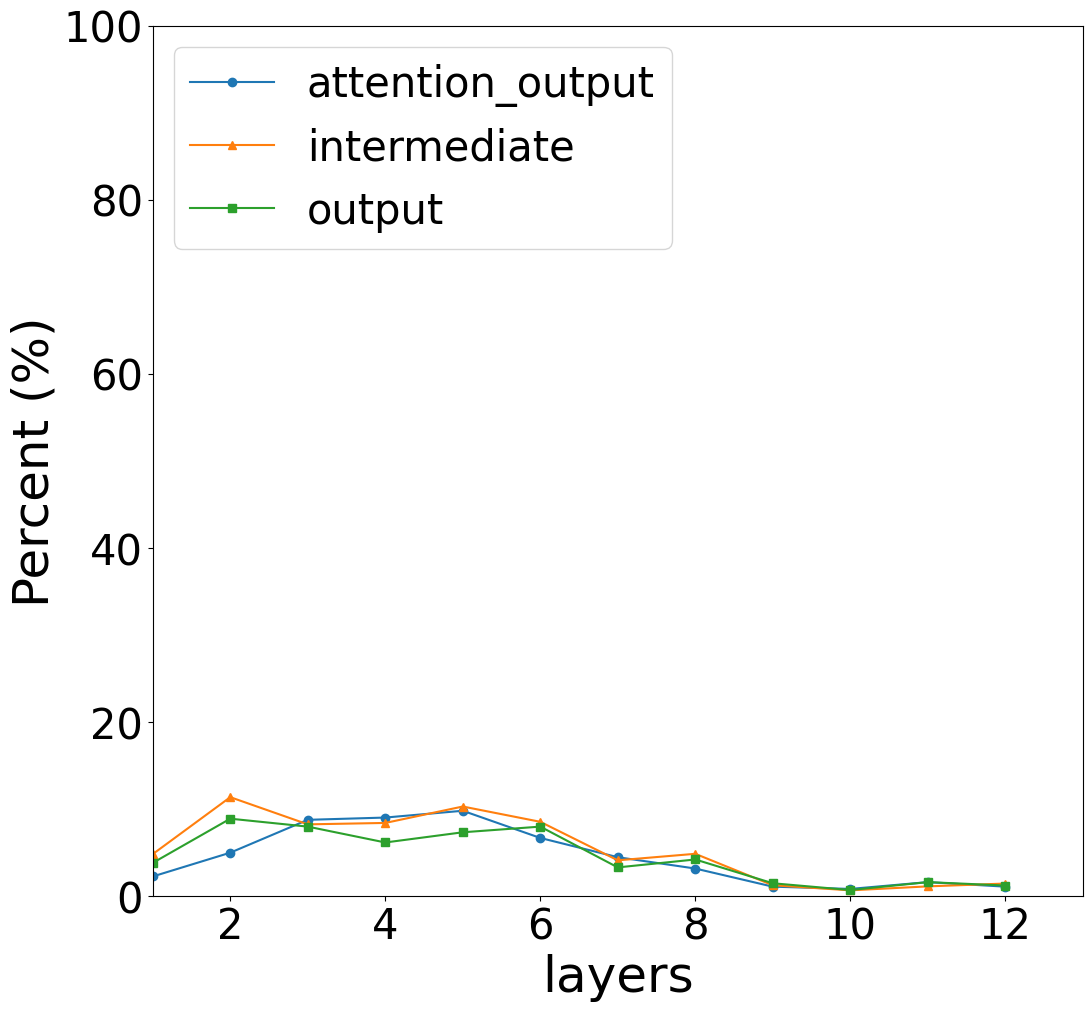

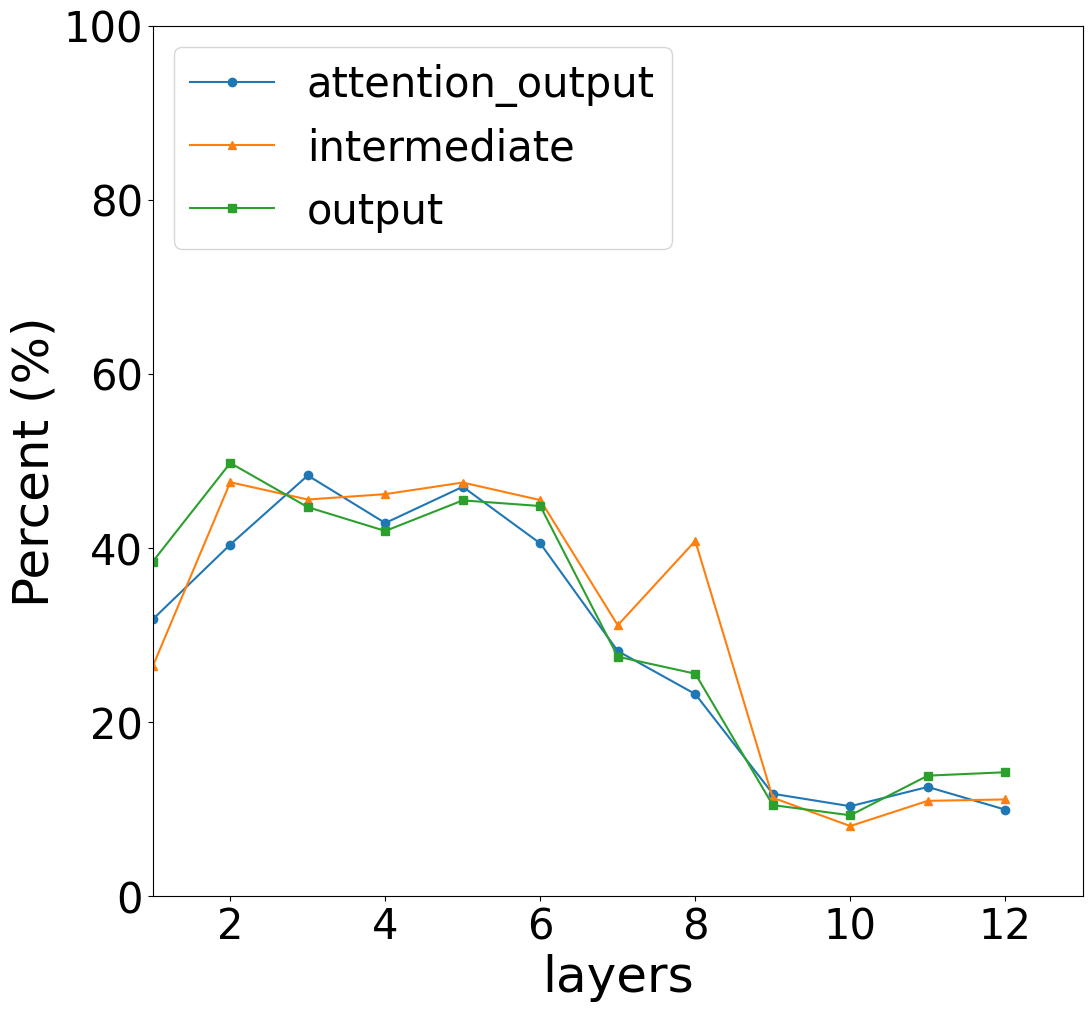

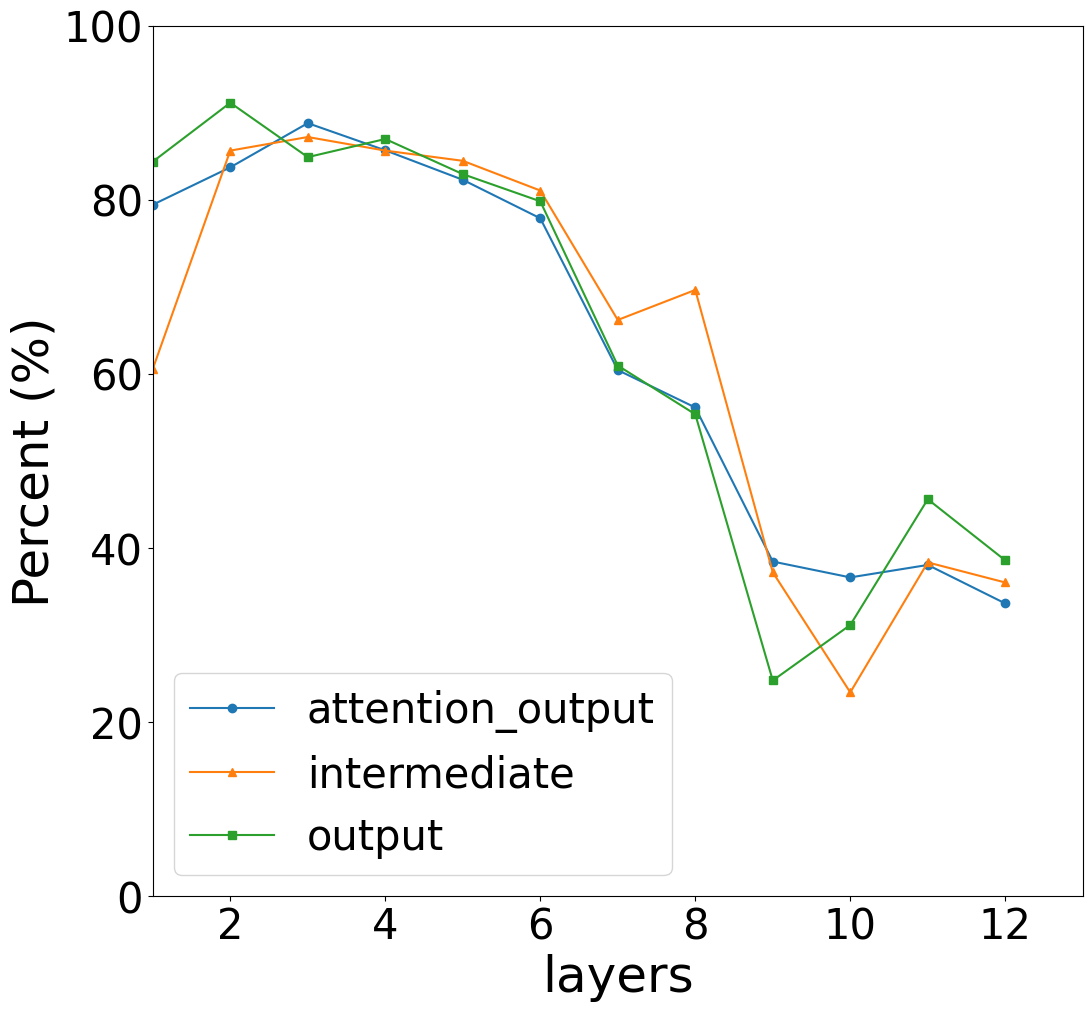

In [13]:
discriminative_sample_file = os.path.join(args.save_discriminative_sample_dir, f"{args.target_name}_{args.probing_dataset}_{get_basename(args.concept_set_file)}.json")

with open(discriminative_sample_file) as f: 
	discriminative_samples =  json.load(f)

skip_cnt = 0
# Some audio lost when generating captions
skip_audio_ids = ['177621-0-0-54.wav', '151359-1-3-0.wav', '160093-3-0-0.wav', '160092-3-0-0.wav', '151359-1-1-0.wav', '151359-1-2-0.wav', '170243-1-0-0.wav', '184805-0-0-58.wav', '155130-1-0-0.wav', '155129-1-1-0.wav', '118496-1-0-0.wav', '17307-1-0-0.wav', '162702-1-0-0.wav', '151359-1-0-0.wav', '118496-1-1-0.wav', '155129-1-0-0.wav']

Ks = [args.K / 5 * i for i in range(3, 6)]
for K in Ks:
	number_per_layer = defaultdict(float)
	for key in discriminative_samples.keys():
		audios = discriminative_samples[key]["highly_filename"]
		member_num = defaultdict(set)
		uninterpretable = True
	
		for audio in audios: 
			audio = audio.split("/")[-1]
			if audio in skip_audio_ids:
				skip_cnt += 1
				print(skip_cnt)
				break
			for cluster_id in clustering[audio].keys():
				member_num[cluster_id].add(audio)
		for num in member_num.values():
			if len(num) >= K:
				uninterpretable = False
				break
		if uninterpretable:
			number_per_layer[key.split("#")[0]] += 1

	plot_data = defaultdict(list)
	if "ast" in args.target_name:
		neuron_number = {"attention_output": 768, "intermediate": 3072, "output": 768}
		layer_names = ["attention_output", "intermediate" , "output"]
		for i in range(12):
			for layer_name in layer_names:
				plot_data[layer_name].append(number_per_layer[f"layer{i}_{layer_name}"] / neuron_number[layer_name] * 100)
	
	elif "beats" in args.target_name:
		neuron_number = {"1": 3072, "2": 768}
		layer_names = ["1", "2"]
		for i in range(12):
			for layer_name in layer_names:
				plot_data[layer_name].append(number_per_layer[f"layer{i}_{layer_name}"] / neuron_number[layer_name] * 100)		

	x = range(1, 13)	
	plt.figure(figsize=(12, 10))
	
	# adjusting layout
	if  "beats" in args.target_name:
		plt.plot(x, plot_data[layer_names[0]], label="first linear layer", marker='o')  # Line plot for list1
		plt.plot(x, plot_data[layer_names[1]], label="second linear layer", marker='^') 	
	else:
		plt.plot(x, plot_data[layer_names[0]], label=layer_names[0], marker='o')  # Line plot for list1
		plt.plot(x, plot_data[layer_names[1]], label=layer_names[1], marker='^')  # Line plot for list2
	
	if "ast" in args.target_name:
		plt.plot(x, plot_data[layer_names[2]], label=layer_names[2], marker='s')  # Line plot for list3

	# Adding titles and labels
	plt.xlabel('layers', fontsize=36)
	plt.ylabel('Percent (%)', fontsize=36)
	plt.xticks(fontsize=30)
	plt.yticks(fontsize=30)
	plt.ylim((0, 100))
	plt.xlim((1, 13))
	if K == 3 or K == 4:
		plt.legend(fontsize=30, loc='upper left')
	else: 
		plt.legend(fontsize=30, loc='lower left')

	# Show the plot
	plt.subplots_adjust(top=0.98)
	plt.show()		
